## Example of Trans-C sampling across independent model states: Regression

This notebook demonstrates Bayesian sampling of a linear polynomial regression problem
using the Product-space sampler.

In [1]:
# general python utility packages
import time
from collections import Counter
from functools import partial

import corner
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.optimize import minimize
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor

In [2]:
from pytransc.analysis.samples import get_transc_samples
from pytransc.analysis.visits import (
    count_state_changes,
    count_total_state_changes,
    get_acceptance_rate_between_states,
    get_autocorr_between_state_jumps,
    get_relative_marginal_likelihoods,
    get_visits_to_states,
)
from pytransc.samplers import run_product_space_sampler, run_mcmc_per_state
from pytransc.samplers.product_space import ProductSpace
from pytransc.utils.auto_pseudo import PseudoPriorBuilders, build_auto_pseudo_prior

### Cross-platform multiprocessing compatibility

**Note on macOS/Windows compatibility:** The functions below are defined in a separate module to ensure compatibility with multiprocessing on macOS and Windows.

- **Why?** macOS and Windows use `spawn` for multiprocessing (not `fork` like Linux)
- **What does this mean?** Functions must be picklable (defined at module level, not inline in notebooks)
- **Solution:** We use `%%writefile` to create a module file while keeping the code visible in the notebook

This ensures the notebook works on Linux, macOS, and Windows without modification.

In [ ]:
%%writefile regression_functions.py
"""
Regression example functions for Trans-C sampling.

These functions are defined in a separate module to ensure compatibility
with multiprocessing on macOS and Windows, which use 'spawn' instead of 'fork'.
"""

import numpy as np
import scipy.stats as stats


def flatten_extend(matrix):
    """Flatten a 2D matrix into a 1D numpy array."""
    flat_list = []
    for row in matrix:
        flat_list.extend(row)
    return np.array(flat_list)


def solveLS(d, G, Cdinv, mu=None, Cmpriorinv=None):
    """Solve the least squares problem given data, design matrix, and covariance matrices."""
    A = np.dot(np.transpose(G), Cdinv)  # Find solution
    GtG = np.dot(A, G)  # G^T C_inv G^T
    if (Cmpriorinv is not None) and (mu is not None):
        GtG += Cmpriorinv
    GtGinv = np.linalg.inv(GtG)  # Inverse of G^TC_inv G
    B = np.dot(A, d)
    if (Cmpriorinv is not None) and (mu is not None):
        B += np.dot(Cmpriorinv, mu)
    mls = np.dot(GtGinv, B)
    return mls, GtGinv


def calcE(dp, dobs, Cdinv, Cmpost, m, muprior, Cmpriorinv):
    """Calculate the evidence for the model given data, prior, and posterior covariances."""
    misfit = 0.5 * (np.dot((dobs - dp), np.dot(Cdinv, (dobs - dp))))
    misfit += 0.5 * (np.dot((muprior - m), np.dot(Cmpriorinv, (muprior - m))))
    f = np.sqrt(2 * np.pi) ** len(dp)
    detCdinv = np.linalg.det(Cdinv)
    detCmpost = np.linalg.det(Cmpost)
    detCmpriorinv = np.linalg.det(Cmpriorinv)
    E = np.sqrt(detCmpost * detCdinv * detCmpriorinv) * np.exp(-misfit) / f
    return E


def getG(x, order):
    """Build design matrix, G for polynomial data fitting, at data points x up to order order."""
    return np.transpose([x ** (i) for i in range(order + 1)])


def _log_likelihood(x, state, dobs, G, Cdinv):
    """Calculate the log likelihood of the data given the model parameters."""
    dpred = np.dot(G[state], x)
    misfit = 0.5 * (np.dot((dobs - dpred), np.dot(Cdinv, (dobs - dpred))))
    f = np.sqrt(2 * np.pi) ** len(dpred)
    detCdinv = np.linalg.det(Cdinv)
    logL = -np.log(f) - misfit + np.log(detCdinv)
    return logL


def _log_prior(x, state, muprior, Cmprior):
    """Calculate the log prior probability of the model parameters."""
    mu = muprior[state]
    cov = Cmprior[state]
    rv = stats.multivariate_normal(
        mean=mu, cov=cov
    )  # instance of multi-dimensional Gaussian
    return rv.logpdf(x)


def log_posterior(x, state, dobs, G, Cdinv, muprior, Cmprior):
    """Multi-state log Posterior PDF evaluation (unnormalized)."""
    log_likelihood = _log_likelihood(x, state, dobs, G, Cdinv)
    log_prior = _log_prior(x, state, muprior, Cmprior)
    return log_likelihood + log_prior

In [ ]:
# Import the functions we just wrote to the module
from regression_functions import (
    flatten_extend,
    solveLS,
    calcE,
    getG,
    _log_likelihood,
    _log_prior,
    log_posterior as _log_posterior_full,
)

--------

## Polynomial regression theory

Here we set up a problem of polynomial regression fitting a set of x,y data with up to a 4th order polynomial.

To begin with, we will work with polynomial curves, $$y(x) = \sum_{n=0}^N m_n x^n\,.$$
Here, $N$ is the 'order' of the polynomial: if $N=1$ we have a straight line, if $N=2$ it will be a quadratic, and so on. The $m_n$ are the 'model coefficients'.

To compute $y(x)$ for multiple $x$-values simultaneously, we  write $$ \left(\begin{array}{c}y_1\\y_2\\\vdots\\y_N\end{array}\right) = \left(\begin{array}{ccc}1&x_1&x_1^2\\1&x_2&x_2^2\\\vdots&\vdots&\vdots\\1&x_N&x_N^2\end{array}\right)\left(\begin{array}{c}m_0\\m_1\\m_2\end{array}\right)$$This has the general form, $\mathbf{d=Gm}$, and so the best-fitting model can be identified using a least-squares algorithm.

The maximum Likelihood solution for this problem is the model which minimizes

$$
\phi(\mathbf{m}) = \frac{1}{2} (\mathbf{d-Gm})^TC_D^{-1} (\mathbf{d-Gm}),
$$
which leads to

$$
{\bf m}_{LS} = \left(\mathbf{G}^T C_D^{-1} \mathbf{G}\right)^{-1}\mathbf{G}^T  C_D^{-1} \mathbf{d}.
$$

The *MAP* model, $\hat{{\bf m}}$, for this problem minimizes of the sum of the negative log-Likelihood and log-Gaussian prior 

$$
\phi(\mathbf{m}) = \frac{1}{2} (\mathbf{d-Gm})^TC_D^{-1} (\mathbf{d-Gm}) + \frac{1}{2} (\mathbf{m - m_o})^TC_M^{-1} (\mathbf{m - m_o})
$$

which leads to

$$
\hat{{\bf m}} = \left(\mathbf{G}^T C_D^{-1} \mathbf{G} + C_M^{-1}\right)^{-1}(\mathbf{G}^T  C_D^{-1} \mathbf{d} + C_M^{-1}\mathbf{m_o}).
$$

For Gaussian Likelihood and prior the evidence is a known analytical expression.

$$
p{(\bf d}) = \frac{e^{-\phi(\hat{{\bf m}})}}{(2\pi)^{N/2}} \left[ \frac{|\hat{C}_M|}{|C_D||C_M|}\right]^{1/2}.
$$
where $\hat{C}_M$ is the posterior model covariance, 

$$
\hat{C}_M = \left(\mathbf{G}^T C_D^{-1} \mathbf{G} + C_M^{-1}\right)^{-1}
$$

We generate some random samples from $y=3x/5+0.3$, add Gaussian random noise to them.

In [7]:
np.random.seed(61254557)  # noqa: NPY002
ndata, sigma = 20, 0.2
xobs = np.sort(np.random.rand(ndata))  # noqa: NPY002 ; x values of data
mtrue = np.array([0.3, 0.6])
G = getG(xobs, 1)
dobs = np.dot(G, mtrue) + np.random.normal(0, sigma, size=len(xobs))  # noqa: NPY002
Cdinv = np.eye(ndata) / (sigma**2)

Set up prior for Evidence calculation.

In [8]:
mls, Cmpost, G, Ev, maxorder = [], [], [], [], 3
Cmprior = [20 * np.eye(i + 1) for i in np.arange(maxorder + 1)]
Cmpriorinv = [0.05 * np.eye(i + 1) for i in np.arange(maxorder + 1)]
muprior = [np.zeros(i + 1) for i in np.arange(maxorder + 1)]

Solve least squares solution and calculate evidence for each model.

In [9]:
for i in range(maxorder + 1):
    Gp = getG(xobs, i)
    solp, Cmp = solveLS(dobs, Gp, Cdinv)  # Maximum Likelihood solution
    dpred = np.dot(Gp, solp)
    mls.append(solp)
    Cmpost.append(Cmp)
    G.append(Gp)
    solp2, Cmp2 = solveLS(
        dobs, Gp, Cdinv, mu=muprior[i], Cmpriorinv=Cmpriorinv[i]
    )  # MAP model and model covariance with Gaussian prior
    dpred2 = np.dot(Gp, solp2)
    Ev.append(
        calcE(dpred2, dobs, Cdinv, Cmp2, solp2, muprior[i], Cmpriorinv[i])
    )  # Analytical evidence calculation
Ev /= np.sum(Ev)

Plot solutions.

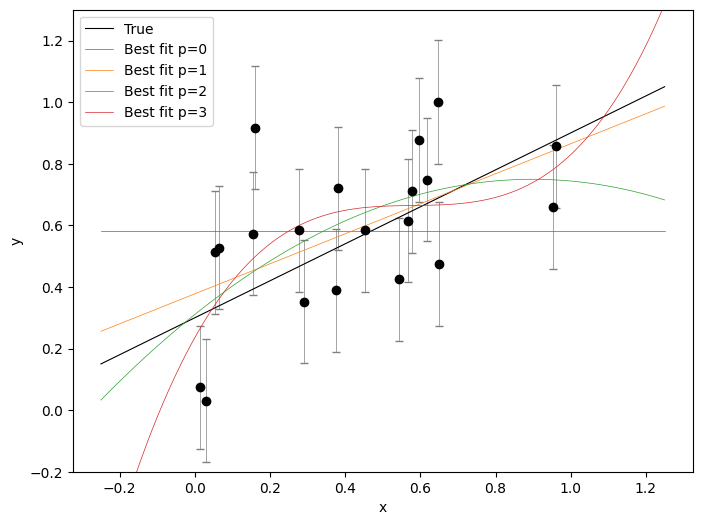

In [10]:
xplot = np.linspace(-0.25, 1.25, 100)
Gplot = getG(xplot, 1)
dplot = np.dot(Gplot, mtrue)
#
plt.figure(figsize=(8, 6))
plt.errorbar(xobs, dobs, yerr=sigma, capsize=3, fmt="ko", ecolor="grey", lw=0.5)
plt.plot(xplot, dplot, label="True", color="k", lw=0.8)
for i in range(maxorder + 1):
    Gplotp = getG(xplot, i)
    dpred = np.dot(Gplotp, mls[i])
    plt.plot(xplot, dpred, label="Best fit p=" + str(i), lw=0.5)
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(-0.2, 1.3)
plt.legend()
plt.show()

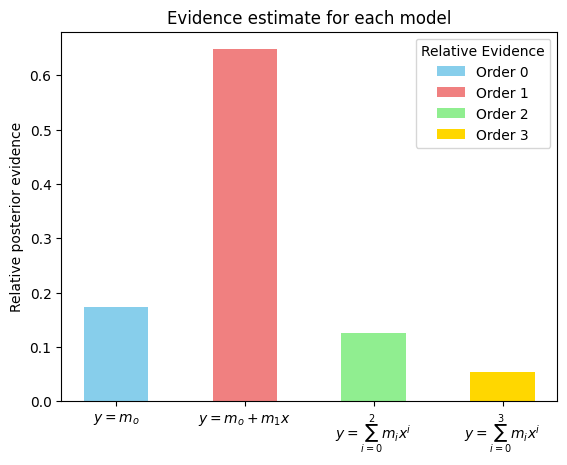

In [11]:
# plot evidence values

fig, ax = plt.subplots()

fruits = [
    r"$y=m_o$",
    r"$y=m_o + m_1x$",
    r"$y = \sum_{i=0}^2 m_ix^i$",
    r"$y = \sum_{i=0}^3 m_ix^i$",
]
counts = [Ev[i] for i in range(maxorder + 1)]
bar_labels = [
    "Order 0",
    "Order 1",
    "Order 2",
    "Order 3",
]  # Define a list of labels, one for each bar

bar_colors = [
    "skyblue",
    "lightcoral",
    "lightgreen",
    "gold",
]  # Define a list of colors, one for each bar

ax.bar(fruits, counts, label=bar_labels, width=0.5, color=bar_colors)

ax.set_ylabel("Relative posterior evidence")
ax.set_title("Evidence estimate for each model")
ax.legend(title="Relative Evidence")

plt.show()

----------------

Set some global control parameters.

In [12]:
plotting = True  # Create some diagnostic displays of outputs
parallel = False  # Use parallel computation for sampling

### Log-posterior Likeihood, prior and PDF for each state

In [ ]:
# Create partial function binding data parameters for likelihood
log_likelihood = partial(_log_likelihood, dobs=dobs, G=G, Cdinv=Cdinv)

In [ ]:
# Create partial function binding prior parameters
log_prior = partial(_log_prior, muprior=muprior, Cmprior=Cmprior)

In [ ]:
# Create partial function binding all data and prior parameters for posterior
# This makes log_posterior(x, state) which is needed for optimization and MCMC
log_posterior = partial(
    _log_posterior_full, dobs=dobs, G=G, Cdinv=Cdinv, muprior=muprior, Cmprior=Cmprior
)

### Starting points for MCMC samplers in each state

In [16]:
# first we optimize each state to find good starting point for all McMC samplers
rng = np.random.default_rng(42)
nstates = maxorder + 1  # Number of distinct states
ndims = [1, 2, 3, 4]  # Number of model parameters in each stateif(True):
nll = lambda *args: -log_posterior(*args)
ml = []
print("Maximum likelihood estimates:")
for i in range(nstates):
    initial = 0.5 * np.ones(i + 1)
    soln = minimize(nll, initial, args=(i,))
    ml.append(soln.x)
    print("x_ml ", soln.x)

Maximum likelihood estimates:
x_ml  [0.58148024]
x_ml  [0.37788932 0.48664354]
x_ml  [ 0.31354801  0.95796058 -0.52400541]
x_ml  [ 0.28548373  1.4395107  -1.83289387  0.89632873]


### Pseudo-prior for each state

Here we use an automatic pseudo prior for each state which corresponds to a best fit multi-dimensional Gaussian to posterior ensembles in each state.

This is built using the function `build_auto_pseudo_prior()` which returns a function which we'll call `log_pseudo_prior()`.

`build_auto_pseudo_prior()` will conduct some quick initial sampling in each state, and fit a Gaussian Mixture to these samples.

In [17]:
# Generate posterior ensembles in each state for pseudo-prior fitting
ensemble_per_state, _ = run_mcmc_per_state(
    n_states=nstates,
    n_dims=ndims,
    n_walkers=nwalkers_auto,
    n_steps=nsteps_auto,
    pos=pos,
    log_posterior=log_posterior,
    auto_thin=autothin,
    verbose=False,
)

# Build pseudo-prior from the posterior ensembles
log_pseudo_prior = build_auto_pseudo_prior(  # noqa: F811
    ensemble_per_state=ensemble_per_state,
    pseudo_prior_type=PseudoPriorBuilders.GAUSSIAN_MIXTURE,
)


## Trans-C samping across model states with the Product-Space sampler 

Here we demonstrate use of the *Product-Space sampler*.

Here we concatenate all model vectors to a single product space model vector and perform MCMC sampling in this larger fixed dimensional space.

In [18]:
# product space sampling set up
nwalkers_ps = 32  # Number of walkers
nsteps_ps = 100000  # Number of chain steps
pos_states = rng.choice(
    np.arange(nstates), nwalkers_ps
).tolist()  # Random initial states of each walker
pos = []
for i in range(nstates):  # generate starting points for each chain in each state
    pos.append(
        ml[i] + 1e-4 * rng.standard_normal((nwalkers_ps, ndims[i]))
    )  # add random perturbation to maximum Likelihood models

#### Parallelisation
`run_product_space_sampler` performs posterior sampling over the larger product space using `emcee`. The parallelisation pool for emcee is exposed in the calling seuqence, allowing the user to control the pool if desired. Here we demonstrate behaviour using a bool.

- `parallel_mode = 0` :Sequential execution (no pool).
- `parallel_mode = 1` :Parallel across states only. Set `n_procs` to a factor of the number of states.

For a more detailed information see the docstring.

In [41]:
parallel_mode = 0

In [42]:
product_space = ProductSpace(ndims)

start_time = time.time()

if(parallel_mode==0): # Sequential execution (no pool)
    result = run_product_space_sampler(
        product_space,
        nwalkers_ps,
        nsteps_ps,
        pos,
        pos_states,
        log_posterior,
        log_pseudo_prior,        progress=True,
    )
elif(parallel_mode ==1): # Demonstrate parallel over 4 processes
    with ProcessPoolExecutor(max_workers=4) as pool:
        result = run_product_space_sampler(
            product_space,
            nwalkers_ps,
            nsteps_ps,
            pos,
            pos_states,
            log_posterior,
            log_pseudo_prior,            pool = pool,
            progress=True,
        )

elapsed_time = time.time() - start_time
print(
    " Elapsed time                                     :",
    np.round(elapsed_time, 2),
    "s \n",
)


Running product space trans-C sampler

Number of walkers               :  32
Number of states being sampled  :  4
Dimensions of each state        :  [1, 2, 3, 4]


100%|████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [2:49:43<00:00,  9.82it/s]


 Elapsed time                                     : 10184.87 s 



#### Run times for different numbers of processes

| Pool type | Elapsed time (s) | Likelihood | Speedup | Nproc | Nwalkers |Chain length|
|:-------------|-------------:|:--------------:|:--------------:|:--------------:|:--------------:|:--------------:|
| Sequential   | 913.1              | Fast |1 | 1     | 32 | 1.E5|
| ProcessPoolExecutor  | 777.5      | Fast |1.17 | 2     | 32 | 1.E5|
| ProcessPoolExecutor  | 500.5      | Fast |1.82 | 4     | 32 | 1.E5|
| ProcessPoolExecutor  | 461.4      | Fast |1.98 | 8     | 32 | 1.E5|
| ProcessPoolExecutor  | 473.3      | Fast |1.93 | 16    | 32 | 1.E5|
| Sequential   | 45611.2           | Slow |1 | 1     | 32 | 1.E5|
| ProcessPoolExecutor  | 10184.9   | Slow |4.47 | 4     | 32 | 1.E5|
| ProcessPoolExecutor  | 5275.4   | Slow |8.65 | 8     | 32 | 1.E5|
| ProcessPoolExecutor  | 2873.2  | Slow |15.87 | 16    | 32 | 1.E5|

Relative execution times may be dependent on the cost of a Likelihood evaluation. Here `Fast` indicates native Likelihood and `Slow` represents Likelihood evaluation with a `time.sleep(0.01)` delay inserted. 

In [21]:
# print some diagnostics
alg = "TransC-product-space"
print("\n Algorithm type                                      :", alg)

# extract trans-C samples and chains
discard = 0  # chain burnin
thin = 20  # chain thinning
visits, states_chain = get_visits_to_states(
    transc_sampler=result,
    discard=discard,
    thin=thin,
    normalize=True,
)
visits = visits.swapaxes(0, 1)  # (n_steps, n_walkers, n_states)
states_chain = states_chain.swapaxes(0, 1)  # (n_steps, n_walkers)

state_changes_per_walker = count_state_changes(
    result.state_chain, discard=discard, thin=thin
)
total_state_changes = count_total_state_changes(
    result.state_chain, discard=discard, thin=thin
)
acceptance_rate_between_states = get_acceptance_rate_between_states(
    result, discard=discard, thin=thin
)
autocorr_time_for_between_state_jumps = get_autocorr_between_state_jumps(
    result.state_chain
)
relative_marginal_likelihoods = get_relative_marginal_likelihoods(
    result.state_chain_tot[-1]
)

print(
    " Auto correlation time of between state jumps        :",
    np.round(autocorr_time_for_between_state_jumps, 3),
)
print(" Total number of state changes for all walkers       :", total_state_changes)
print(
    " Number of state changes for each walker             :\n",
    *state_changes_per_walker,
)
print(
    " Average % acceptance rate for between state changes :",
    acceptance_rate_between_states,
)
print(" Analytical relative marginal Likelihoods            :", *np.round(Ev, 5))
print(
    " Estimated relative evidences                        :",
    *np.round((relative_marginal_likelihoods), 5),
)
print(
    " Elapsed time.                                       :",
    np.round(elapsed_time, 2),
    "s \n",
)


 Algorithm type                                      : TransC-product-space
 Auto correlation time of between state jumps        : 156.541
 Total number of state changes for all walkers       : 46234
 Number of state changes for each walker             :
 1460 1450 1407 1453 1452 1501 1427 1361 1505 1492 1493 1446 1444 1480 1463 1359 1459 1441 1449 1463 1420 1483 1461 1410 1532 1434 1442 1422 1441 1418 1344 1422
 Average % acceptance rate for between state changes : 28.89625
 Analytical relative marginal Likelihoods            : 0.17306 0.64752 0.12509 0.05433
 Estimated relative evidences                        : 0.16974 0.64664 0.12496 0.05866
 Elapsed time.                                       : 1339.02 s 



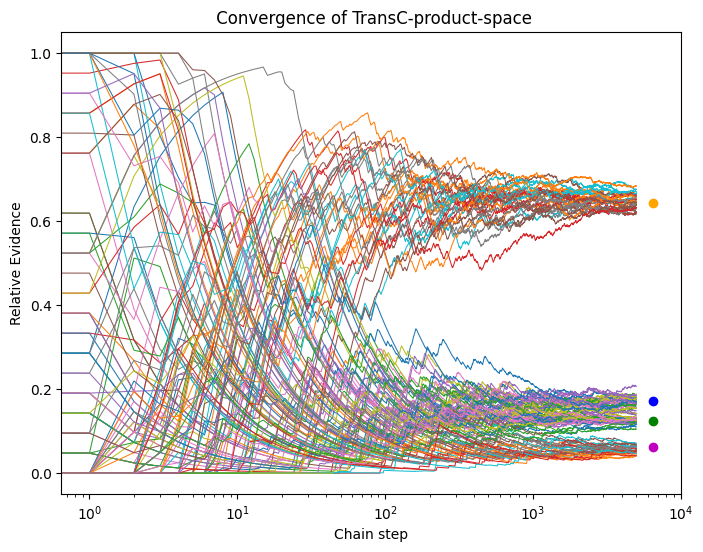

In [22]:
# plot relative number of visit to each state along the chain
if plotting:
    fig, axes = plt.subplots(figsize=(8, 6))
    if visits.ndim == 3:  # plot chains for each state and walker
        plt.semilogx(visits.reshape(np.shape(visits)[0], -1), lw=0.75)
    elif visits.ndim == 2:  # plot chains for each state average over walkers
        plt.semilogx(
            visits.reshape(np.shape(visits)[0], -1),
            lw=0.75,
            label=["State 1", "State 2", "State 3"],
        )
        plt.legend()
    plt.xlabel("Chain step")
    plt.ylabel("Relative Evidence")
    plt.plot(len(visits) * 1.3, Ev[0], "bo")
    plt.plot(len(visits) * 1.3, Ev[1], "o", color="orange")
    plt.plot(len(visits) * 1.3, Ev[2], "go")
    plt.plot(len(visits) * 1.3, Ev[3], "mo")
    plt.title(" Convergence of " + alg)
    # plt.savefig('PS_chains.pdf')
    plt.show()

Coloured dots show the true relative normalization constants for each Gaussian. As you can see the chains of the Product-space sampler are 
converging, and visiting each state in proportion to the correct normalization constant. 

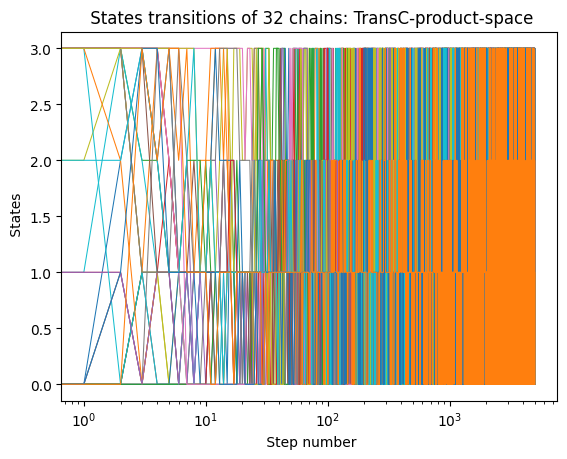

In [23]:
# plot chain states
if plotting:
    # plot chains for each state and walker
    plt.semilogx(states_chain.reshape(np.shape(states_chain)[0], -1), lw=0.75)
    plt.xlabel(" Step number")
    plt.ylabel(" States")
    title = " States transitions of " + str(nwalkers_ps) + " chains: " + alg
    plt.title(title)
    # plt.savefig('PS_chain_transistions.pdf')
    plt.show()

This plot shows the movement of each chain between states.

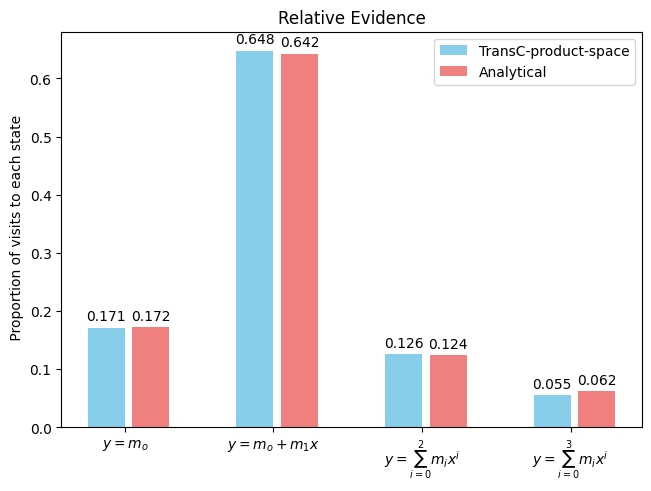

In [24]:
# Count visits to each state by Trans-D mcmc
if plotting:
    h = np.zeros(nstates)
    h[list(Counter(states_chain.reshape(-1)).keys())] = list(
        Counter(states_chain.reshape(-1)).values()
    )
    h /= np.sum(h)
    # plot histogram of frequency of visits to each state

    labels = [
        r"$y=m_o$",
        r"$y=m_o + m_1x$",
        r"$y = \sum_{i=0}^2 m_ix^i$",
        r"$y = \sum_{i=0}^3 m_ix^i$",
    ]
    x = np.arange(nstates)  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout="constrained")
    offset = width * multiplier
    rects = ax.bar(x + offset, np.round(h, 3), width, label=alg, color="skyblue")
    ax.bar_label(rects, padding=3)
    multiplier += 1
    offset = width * multiplier + 0.05
    rects = ax.bar(
        x + offset, np.round(counts, 3), width, label="Analytical", color="lightcoral"
    )
    ax.bar_label(rects, padding=3)
    multiplier += 1
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(" Proportion of visits to each state")
    ax.set_title("Relative Evidence")
    ax.set_xticks(x + width / 2, labels)
    ax.legend(loc="upper right")
    # plt.savefig('PS_relative_evidences.pdf')
    plt.show()

 State;  1  in  2  dimensions
 State;  2  in  3  dimensions
 State;  3  in  4  dimensions


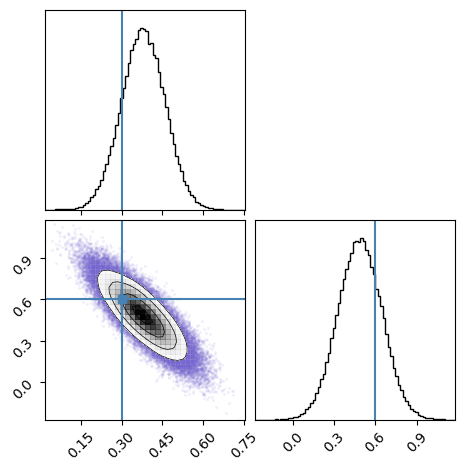

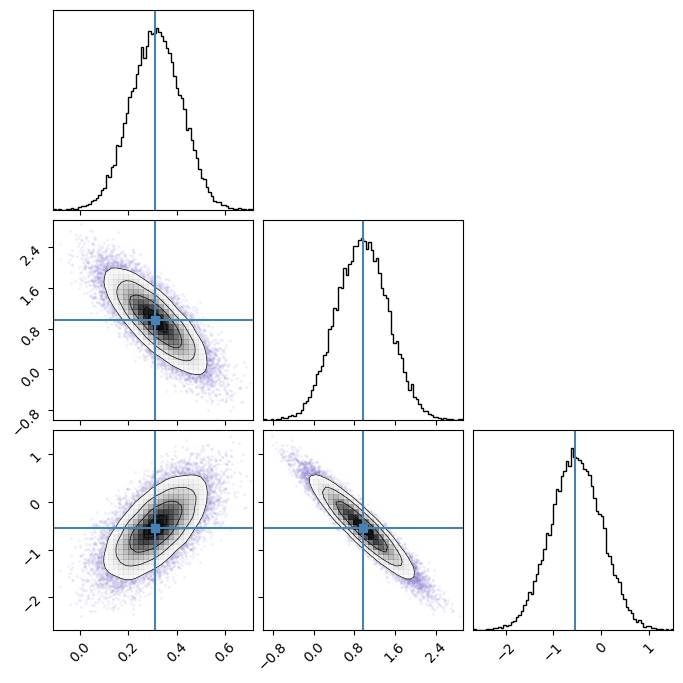

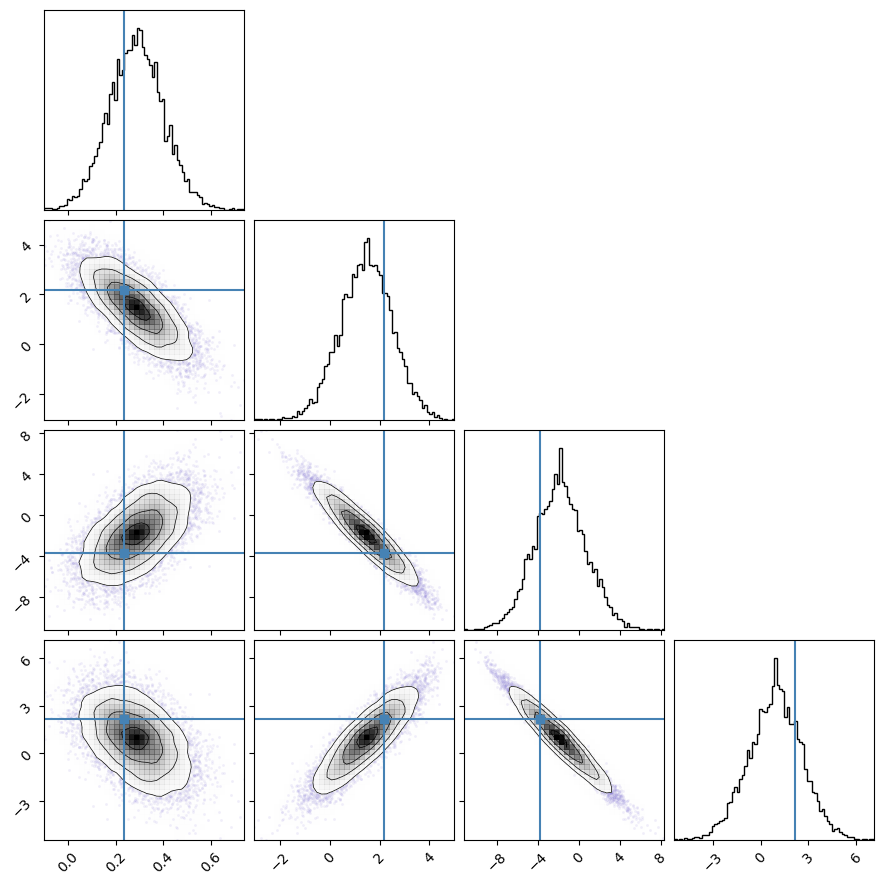

In [25]:
# corner plots to check sampling within each state
if plotting:
    muplot = mls.copy()
    muplot[1] = mtrue
    # collect trans samples
    transc_ensemble = get_transc_samples(
        result,
        discard=0,
        thin=thin,
    )
    contour_kwargs = {"linewidths": 0.5}
    data_kwargs = {"color": "slateblue"}
    for i in range(1, nstates):
        string = "Order " + str(i)
        print(" State; ", i, " in ", ndims[i], " dimensions")
        fig = corner.corner(
            transc_ensemble[i],
            truths=muplot[i],
            title=string,
            bins=40,
            hist_bin_factor=2,
            smooth=True,
            contour_kwargs=contour_kwargs,
            data_kwargs=data_kwargs,
        )
# fig.savefig('PS_corner_'+str(i)+'.pdf')

In [26]:
print(
    f" Here is the Trans-C ensemble with\n {len(transc_ensemble[0])} samples in state 1\n {len(transc_ensemble[1])} samples in state 2\n {len(transc_ensemble[2])} samples in state 3\n",
    "\n",
    transc_ensemble,
)

 Here is the Trans-C ensemble with
 27369 samples in state 1
 103752 samples in state 2
 20093 samples in state 3
 
 [array([[0.57938982],
       [0.58362349],
       [0.58478542],
       ...,
       [0.64153888],
       [0.58739367],
       [0.60503688]], shape=(27369, 1)), array([[0.42281168, 0.50358582],
       [0.36823394, 0.4559563 ],
       [0.28757444, 0.62596636],
       ...,
       [0.297601  , 0.61513082],
       [0.33184545, 0.64941636],
       [0.33603046, 0.54245028]], shape=(103752, 2)), array([[ 0.31356363,  0.95793821, -0.52420931],
       [ 0.15711087,  1.92243979, -1.52086034],
       [ 0.2057003 ,  1.25408025, -0.78741186],
       ...,
       [ 0.24187137,  1.27098955, -0.68614957],
       [ 0.42546079,  0.14467445,  0.19442841],
       [ 0.1719932 ,  1.42834183, -1.10699964]], shape=(20093, 3)), array([[ 0.48971866,  0.90851111, -1.60306272,  0.90112737],
       [ 0.4514145 ,  1.26743364, -2.36647061,  1.33759429],
       [ 0.36424766,  1.15981065, -0.92746387,  0.1

---------